# Toxicity Bias Logistic Regression, TfidfVectorizer


* **1. Introduction**
* **2. Data preparation**
    * 2.1 Loading packages
    * 2.2 Load data
    * 2.3 Show head of data
    * 2.4 Drop NAN values
* **3. Clean data**
    * 3.1 TfidfVectorizer
* **4. Machine learning**
    * 4.1 Split data
    * 4.2 Define Model
    * 4.3 Fit Model
* **4. Evaluate the model**
    * 4.1 Confusion matrix
    * 4.2 Classification report
    * 4.3 Receiver Operating Characteristic
* **5. Prediction and submition**
    * 5.1 Prediction validation results
    * 5.2 Submition
* **6. References**

# Introduction

In this kernel I used simple skleaen model "Logistic Regression" and Clean data with sklean feature extraction text tool called TfidfVectorizer.

Our goal in this competition we are asked to build a model that recognizes toxicity and minimizes unintended bias

# 2. Data preparation
## 2.1 Loading package

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pickle

In [13]:
import os
print(os.listdir("input"))

['test.csv', 'test_private_expanded.csv', 'toxicity_individual_annotations.csv', 'identity_individual_annotations.csv', 'test_public_expanded.csv', 'train.csv', 'all_data.csv', 'sample_submission.csv']


In [14]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.2.


## 2.2 Load data

In [16]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
sub = pd.read_csv('input/sample_submission.csv')

In [34]:
df = train_df.copy()

## 2.3 Show head of data

In [18]:
test_df.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [44]:
df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [127]:
# filter columns that are float:
risk_traits = df.select_dtypes(include=['float64']).columns
risk_traits = risk_traits.drop('target').drop('parent_id')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [40]:
percent = (df[df["target"] > 0.5].shape[0] / df.shape[0]) * 100
percent


5.8972537695152125

In [129]:
out_of_competition_traits = ["severe_toxicity", "obscene", "identity_attack", "insult", "threat", "sexual_explicit"]
risk_traits = risk_traits.drop(out_of_competition_traits)
risk_traits

Index(['asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian',
       'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity',
       'other_religion', 'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white'],
      dtype='object')

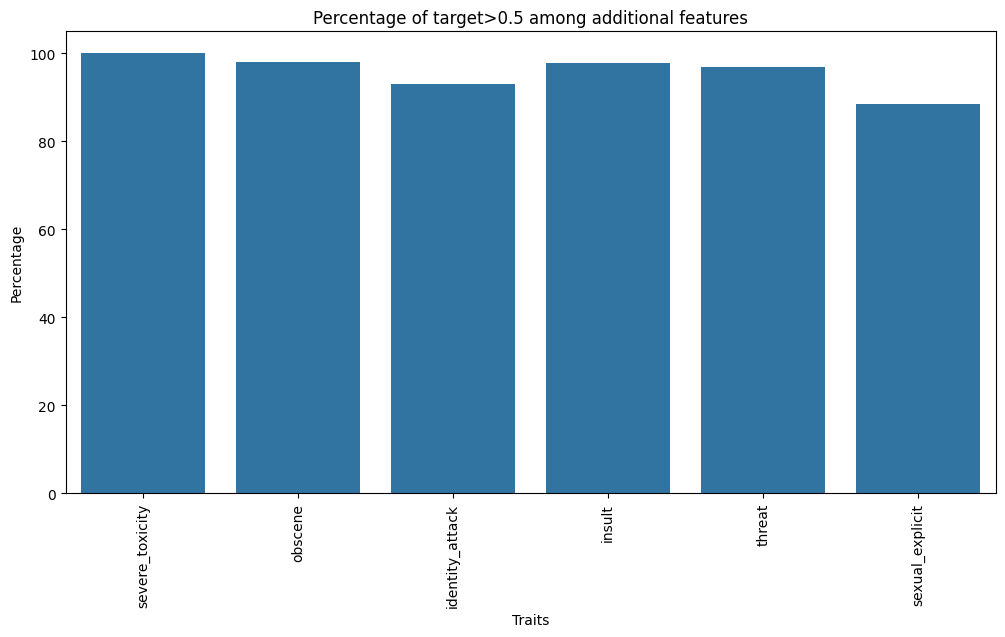

In [63]:
percents = []
for trait in out_of_competition_traits:
    # Filter the dataframe based on the condition where some other features are each >0.5
    filtered_df = df[df[trait] > 0.5]
    # Compute the percent of target>0.5 among the filtered categories
    percent = (filtered_df[filtered_df['target'] > 0.5].shape[0] / filtered_df.shape[0]) * 100
    percents.append(percent)


plt.figure(figsize=(12, 6))
sns.barplot(x=out_of_competition_traits, y=percents)
plt.xlabel('Traits')
plt.ylabel('Percentage')
plt.title('Percentage of target>0.5 among additional features')
plt.xticks(rotation=90)
plt.show()


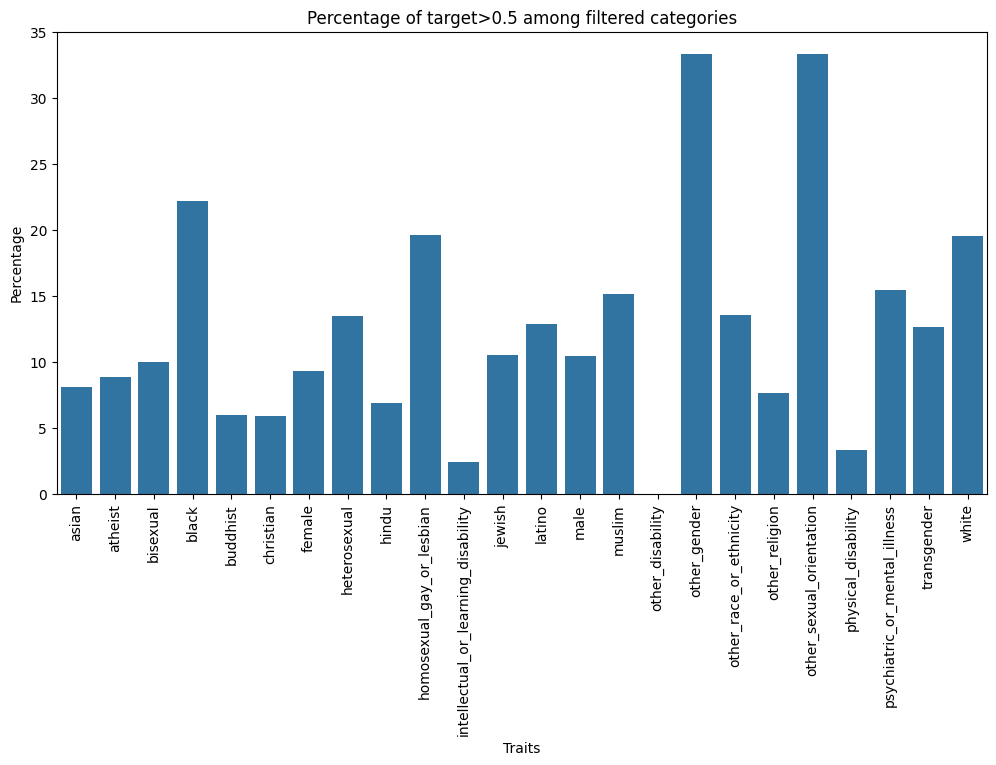

In [62]:
percents = []
for trait in risk_traits:
    # Filter the dataframe based on the condition where some other features are each >0.5
    filtered_df = df[df[trait] > 0.5]
    # Compute the percent of target>0.5 among the filtered categories
    percent = (filtered_df[filtered_df['target'] > 0.5].shape[0] / filtered_df.shape[0]) * 100
    percents.append(percent)

percents


plt.figure(figsize=(12, 6))
sns.barplot(x=risk_traits, y=percents)
plt.xlabel('Traits')
plt.ylabel('Percentage')
plt.title('Percentage of target>0.5 among identity traits')
plt.xticks(rotation=90)

plt.show()

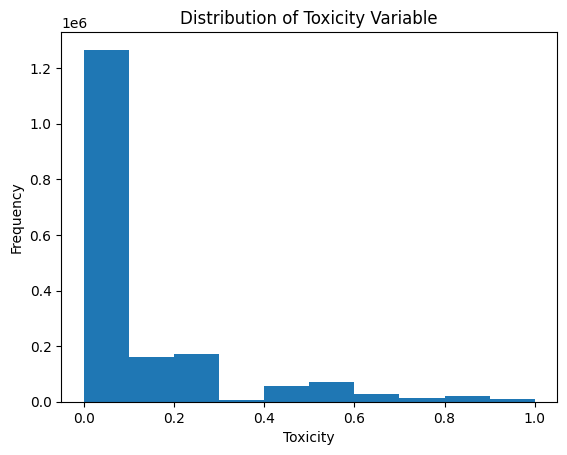

In [68]:
plt.hist(train_df['target'], bins=10)
plt.xlabel('Toxicity')
plt.ylabel('Frequency')
plt.title('Distribution of Toxicity Variable')
plt.show()

In [125]:
risk_all

['male', 'female', 'transgender', 'other_gender']

In [150]:
risk_all = risk_traits
risk_gender = ['male', 'female', 'transgender', 'other_gender']
risk_sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
risk_religion = [
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion'
                  ]
risk_disability = ['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']

for risk in [risk_gender, risk_sexual_orientation, risk_religion, risk_disability]:
    for el in risk:
        assert el in risk_all, f"{el} not"


In [151]:
risks = {
    # "Disability" : risk_disability,
    # "Gender" : risk_gender,
    # "Sexual Orientation" : risk_sexual_orientation,
    "Religion" : risk_religion
}

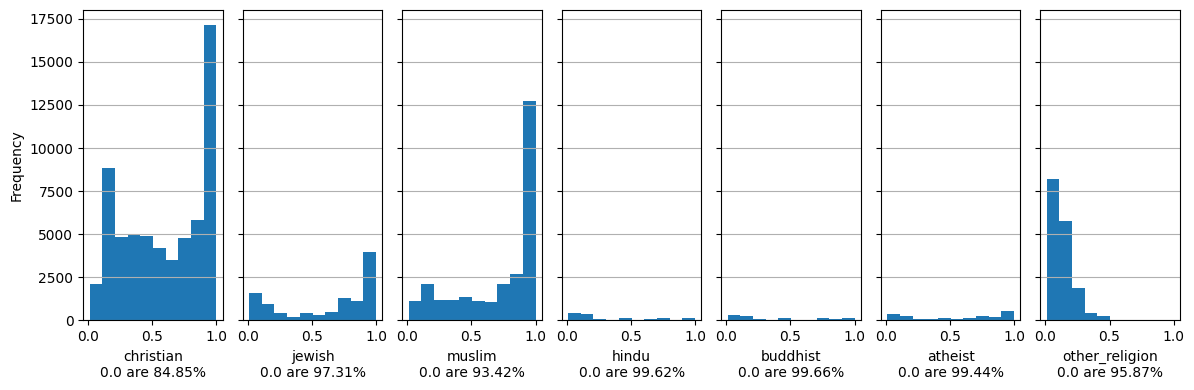

In [152]:
for risk, traits in risks.items():
    num_cols = len(traits)
    num_rows = 1

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4), sharey=True)

    # Make sure axes is an array even if there's only one plot
    axes = np.array(axes).flatten()

    # Iterate over the traits and create a histogram for each
    for i, trait in enumerate(traits):
        zeros_are = df[trait].value_counts(normalize=True).get(0, 0) * 100
        axes[i].hist(df[trait], bins=10, range=(0.01, 1))
        axes[i].set_xlabel(f"{trait}\n0.0 are {zeros_are:.2f}%")
        if i == 0:  # Set the ylabel only for the first subplot
            axes[i].set_ylabel('Frequency')
        axes[i].grid(axis='y')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Add an overall title above all subplots if desired
    # fig.suptitle('Your Title Here', fontsize=16)

    # Show the plot
    plt.show()
    # break  # Only plots the first set of traits; remove if you want to plot for all risks


In [19]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


## 2.4 Drop NAN values

In [9]:
df.dropna(axis=1, inplace=True)

# 3. Clean data
## 3.1 TfidfVectorizer

Convert a collection of raw documents to a matrix of TF-IDF features.

In [10]:
Vectorize = TfidfVectorizer()

X = Vectorize.fit_transform(df["comment_text"])

test_X = Vectorize.transform(test_df["comment_text"])

In [11]:
pickle.dump(Vectorize, open("Vectorize.pickle", "wb"))

In [12]:
y = np.where(train_df['target'] >= 0.5, 1, 0)

In [13]:
X.shape, y.shape, test_X.shape

((1804874, 318304), (1804874,), (97320, 318304))

# 4. Machine learning
## 4.1 Split data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

## 4.2 Define Model

In [15]:
lr = LogisticRegression(C=5, random_state=42, solver='sag', max_iter=1000, n_jobs=-1)

## 4.3 Fit model

In [16]:
lr.fit(X_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [17]:
cv_accuracy = cross_val_score(lr, X, y, cv=5, scoring='roc_auc')
print(cv_accuracy)
print(cv_accuracy.mean())

[0.94607756 0.94436349 0.94531875 0.94375522 0.94326619]
0.9445562410874093


# 4. Evaluate the model

In [18]:
Pkl_Filename = "Pickle_RL_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lr, file)

In [19]:
X_test

<601625x318304 sparse matrix of type '<class 'numpy.float64'>'
	with 23183769 stored elements in Compressed Sparse Row format>

In [20]:
y_pred = lr.predict(X_test)

## 4.1 Confusion matrix

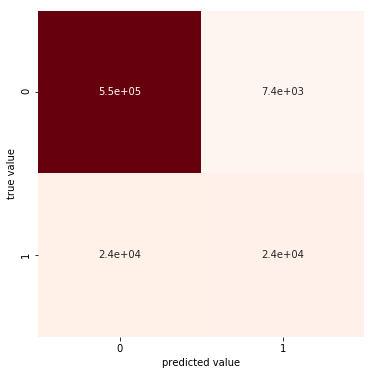

In [21]:
plt.figure(figsize=(8, 6))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Reds')
plt.xlabel('predicted value')
plt.ylabel('true value');

## 4.2 Classification report

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    553213
           1       0.77      0.50      0.60     48412

    accuracy                           0.95    601625
   macro avg       0.86      0.74      0.79    601625
weighted avg       0.94      0.95      0.94    601625



## 4.3 Receiver Operating Characteristic

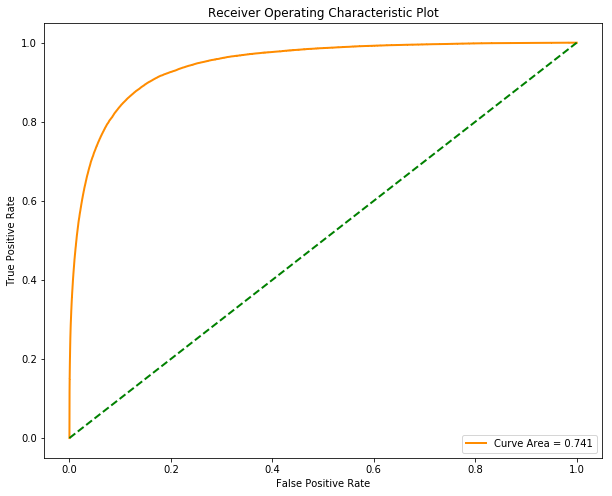

In [23]:
fpr, tpr, thr = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
#auc = auc(fpr, tpr)
auc = roc_auc_score(y_test, y_pred)
lw = 2
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
plt.legend(loc="lower right")
plt.show()

# 5. Prediction and submission
## 5.1 Prediction validation results

In [24]:
predictions = lr.predict_proba(test_X)[:,1]

## 5.2 Submission

In [25]:
sub['prediction'] = predictions
sub.to_csv('submission.csv', index=False)

In [26]:
sub.head(15)

,id,prediction
0,7097320,0.039710
1,7097321,0.045314
2,7097322,0.079036
3,7097323,0.022333
4,7097324,0.004591
5,7097325,0.004256
6,7097326,0.998521
7,7097327,0.357960
8,7097328,0.004580
9,7097329,0.008516


# 6. References

1. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [27]:
vectorizer = pickle.load(open("Vectorize.pickle", "rb"))

In [28]:
# Define a dictionary containing employee data 
data = {'comment_text':['you are amazing']} 
   
# Convert the dictionary to DataFrame  
df = pd.DataFrame(data) 

In [29]:
testing = vectorizer.transform(data["comment_text"])

In [30]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [31]:
# Predict the Labels using the reloaded Model
Ypredict = Pickled_LR_Model.predict_proba(testing)  

Ypredict

array([[0.96189123, 0.03810877]])